In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from dataloader import MRIDataset
from residual3dunet.model import ResidualUNet3D
import matplotlib.pyplot as plt
from torchsummary import summary
from utils import get_loaders
#from residual3dunet.modelorig import ResidualUNet3D

In [37]:
dataset = MRIDataset(train=True)
train, val = torch.utils.data.random_split(dataset, [40, 10])

dataloader = DataLoader(dataset = train, batch_size= 41, shuffle= True, num_workers=2)

In [4]:
# dataset = MRIDataset(train=True, transform=True)

train_kwargs = {'batch_size': 10}
cuda_kwargs = {'num_workers': 1, 'pin_memory': True,'shuffle': True}
train_kwargs.update(cuda_kwargs)

#train, val = random_split(dataset, [40, 10])

# dataloader = DataLoader(dataset = val, **train_kwargs)

In [5]:
dataloader, valloader = get_loaders(train=True, transform=True, **train_kwargs)

In [6]:
dataiter = iter(dataloader)
data = dataiter.next()
features, labels = data
print(features.shape)
print(labels.shape)

torch.Size([10, 1, 14, 240, 240])
torch.Size([10, 1, 14, 240, 240])


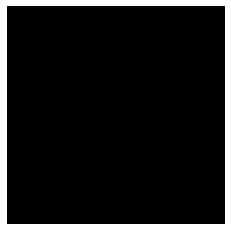

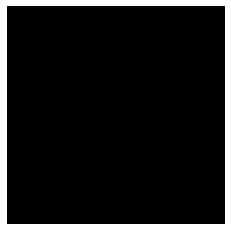

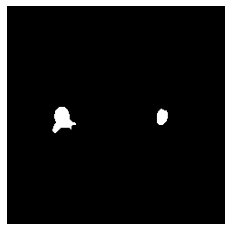

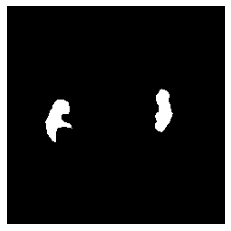

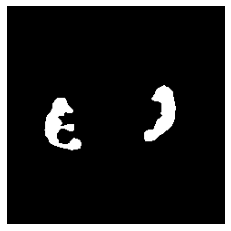

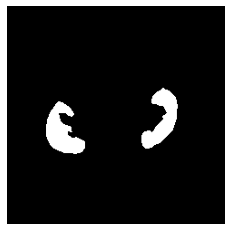

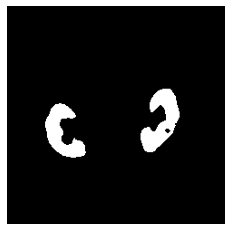

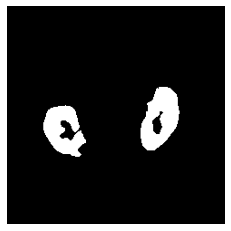

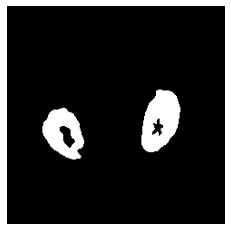

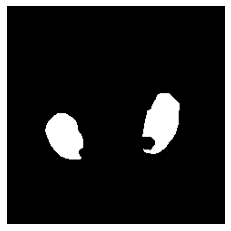

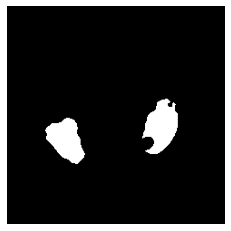

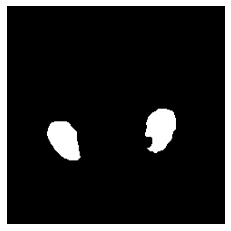

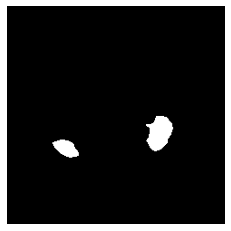

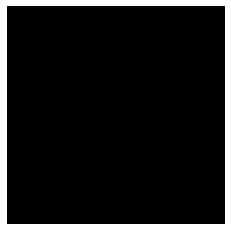

In [36]:
for i in range(14):
    plt.imshow(labels[0,0,i,:,:],cmap='gray')
    plt.axis('off')
    plt.show()

In [4]:
model = ResidualUNet3D(in_channels=1, out_channels=1)

In [6]:
x = torch.randn(size=(1, 1, 14, 240, 240), dtype=torch.float64)

In [7]:
len(dataloader.dataset)

1

In [6]:
out = model(x.float())

torch.Size([64, 1, 14, 240, 240])
